In [13]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path
sns.set(font_scale=1.6, style="ticks")

In [14]:
runs_folder = Path("../../../runs/cov_countries")
data_folder = Path("../../../data/gisaid/cov/spike_rbd_processed_countries")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)

# NLL & revNLL

In [15]:
testing_window=3
year_and_month_all = ("2021-07", "2021-10","2022-01", "2022-04")
countries="africa/south_africa asia/china asia/india asia/indonesia asia/israel asia/japan asia/south_korea europe/austria europe/belgium europe/czech_republic europe/denmark europe/france europe/germany europe/ireland europe/italy europe/luxembourg europe/netherlands europe/norway europe/poland europe/russia europe/slovenia europe/spain europe/sweden europe/switzerland europe/turkey europe/united_kingdom north_america/canada north_america/mexico north_america/usa oceania/australia south_america/brazil south_america/peru"
locations=countries.split()

def get_nlls(df):
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    
    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())

    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
    freqs = torch.mean(freqs, dim=1)
    freqs = freqs / torch.sum(freqs)
    
    token_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy()).float()
    assert torch.sum(token_num != torch.mean(token_num, dim=1, keepdims=True)).item() == 0
    token_num = torch.mean(token_num, dim=1)
    
    nll = torch.sum(freqs * nlls) / torch.sum(freqs * token_num) # average over token number
    return nll

def read_all_nll(path, id2location):
    if isinstance(path, Path):
        if not os.path.exists(path):
            print(path)
            return None
        
        df = pd.read_csv(path)
        locations = []
        for src_id in df["src_id"]:
            locations.append(id2location[src_id])
        df["location"] = locations
        return df
    elif isinstance(path, dict):
        all_dfs = []
        for location, p in path.items(): 
            df = pd.read_csv(p)
            locations = [location] * len(df)
            df["location"] = locations
            all_dfs.append(df)
        return pd.concat(all_dfs)

time2location_to_count = dict()
id2location = dict()

for year_and_month in year_and_month_all:
    year, month = year_and_month.split("-")
    year = int(year)
    
    testing_index = (year - 2020) * 12 / testing_window + (int(month) + testing_window - 1) / testing_window
    
    total_bin_size=0
    data_bin_size=0
    location_to_count = defaultdict(int)
    
    all_test_path = data_folder / f"2020-01_to_2023-12_3M/all/human_minBinSize100_minLen223_maxLen223_location_region2_bins/{int(testing_index)}.fasta"
    bin_size=int(next(SeqIO.parse(all_test_path, "fasta")).description.split("bin_size=")[1].split("|")[0])
    data_bin_size+=bin_size

    for record in SeqIO.parse(all_test_path, "fasta"):
        desc = record.description.split()[1].split("|")
        desc = {x.split("=")[0]: x.split("=")[1] for x in desc}
        id2location[record.id] = desc["location"]
        location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))

    print("Total number of seqs:",  data_bin_size, sum(location_to_count.values()))
    
    time2location_to_count[year_and_month] = location_to_count


Total number of seqs: 2477483 2477484
Total number of seqs: 2933995 2933994
Total number of seqs: 1428917 1428916
Total number of seqs: 1227563 1227562


In [16]:
nll_results = defaultdict(list)

for test_rev_dir in ("test_rev_1",  "test_rev_2", "test_rev_3"):
    print(">>>", test_rev_dir)

    for year_and_month in year_and_month_all:
        print(year_and_month)
        year, month = year_and_month.split("-")
        year = int(year)

        for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
            name2nll_path = {
                    "Prepend": runs_folder / f"2020-01_to_{year_and_month}_1M/prepend/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
         
                    "G2L/random": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/country_to_continent/random_3_20-7-5/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2L/clustering": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/country_to_continent/agg_complete_3/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",

                    "G2G/random": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/continent_to_continent/random_3_20-7-5/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2G/clustering": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/continent_to_continent/agg_complete_3/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",


                }
            model2nll = dict()
            for model in name2nll_path:
                model2nll[model] = read_all_nll(name2nll_path[model], id2location)
      
            for location in locations:
                continent, country = location.split("/")

                name2rev_nll_path = {
                    "G2L/clustering": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/country_to_continent/agg_complete_3/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2G/clustering": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/continent_to_continent/agg_complete_3/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",

                    "G2L/random": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/country_to_continent/random_3_20-7-5/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2G/random": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/continent_to_continent/random_3_20-7-5/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    
                    "Prepend": runs_folder / f"2020-01_to_{year_and_month}_1M/prepend/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    
                }


                for name, _path in name2nll_path.items():
                    our_model_path_rev_nll = name2rev_nll_path[name] # os.path.join(_path, "test_rev/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (continent, temperature))

                    if os.path.exists(our_model_path_rev_nll) and name in model2nll:
                        df = model2nll[name]
                        nll = get_nlls(df[df["location"] == location])
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["location"].append(location)
                        nll_results["model"].append(name)
                        nll_results["time"].append(year_and_month)
                        nll_results["bin_size"].append(time2location_to_count[year_and_month][location])
                        nll_results["oracle"].append(test_rev_dir)


                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print(our_model_path_rev_nll)

                        if model not in model2nll:
                            print(model)

nll_results = pd.DataFrame(nll_results)
print(nll_results)
ori_nll_results = nll_results

>>> test_rev_1
2021-07
2021-10
2022-01
2022-04
>>> test_rev_2
2021-07
2021-10
2022-01
2022-04
>>> test_rev_3
2021-07
2021-10
2022-01
2022-04
           NLL  reverse NLL  temperature             location           model  \
0     0.282388     0.013775          0.2  africa/south_africa         Prepend   
1     0.273300     0.010964          0.2  africa/south_africa      G2L/random   
2     0.274146     0.012915          0.2  africa/south_africa  G2L/clustering   
3     0.269990     0.009214          0.2  africa/south_africa      G2G/random   
4     0.271005     0.009773          0.2  africa/south_africa  G2G/clustering   
...        ...          ...          ...                  ...             ...   
9595  0.057922     0.045698          1.0   south_america/peru         Prepend   
9596  0.058277     0.042227          1.0   south_america/peru      G2L/random   
9597  0.055273     0.049955          1.0   south_america/peru  G2L/clustering   
9598  0.057222     0.055684          1.0   south_

In [17]:
def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df["NLL"]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df["reverse NLL"]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df["NLL"])
            ave_rev_nll = np.mean(_df["reverse NLL"])
        
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results["nll"].append(ave_nll)
        summary_nll_results["rev_nll"].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))

    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    return summary_nll_results

In [18]:
local_summary_df = get_summary(nll_results, keys=("model", "temperature", "location", "oracle"), weighted_average=False)


In [19]:
nll_results[nll_results["bin_size"]>=min_count]

,NLL,reverse NLL,temperature,location,model,time,bin_size,oracle
0,0.282388,0.013775,0.2,africa/south_africa,Prepend,2021-07,7999,test_rev_1
1,0.273300,0.010964,0.2,africa/south_africa,G2L/random,2021-07,7999,test_rev_1
2,0.274146,0.012915,0.2,africa/south_africa,G2L/clustering,2021-07,7999,test_rev_1
3,0.269990,0.009214,0.2,africa/south_africa,G2G/random,2021-07,7999,test_rev_1
4,0.271005,0.009773,0.2,africa/south_africa,G2G/clustering,2021-07,7999,test_rev_1
...,...,...,...,...,...,...,...,...
9595,0.057922,0.045698,1.0,south_america/peru,Prepend,2022-04,11160,test_rev_3
9596,0.058277,0.042227,1.0,south_america/peru,G2L/random,2022-04,11160,test_rev_3
9597,0.055273,0.049955,1.0,south_america/peru,G2L/clustering,2022-04,11160,test_rev_3
9598,0.057222,0.055684,1.0,south_america/peru,G2G/random,2022-04,11160,test_rev_3


['G2G/clustering', 'G2G/random', 'G2L/clustering', 'G2L/random', 'Prepend']
['G2G/clustering', 'G2G/random', 'G2L/clustering', 'G2L/random', 'Prepend']


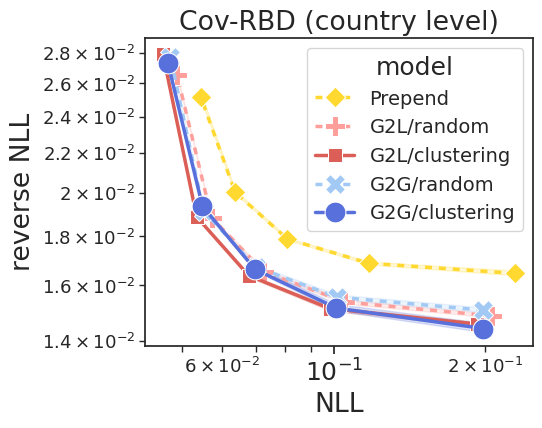

In [20]:
import matplotlib.ticker as ticker


min_count=1000

summary_summary_df = get_summary(nll_results[nll_results["bin_size"]>=min_count], keys=("model", "temperature", "oracle"), weighted_average=False)


plt.xscale('log')
plt.yscale('log')


plt.rcParams['figure.figsize'] = 5, 4
plt.rcParams['lines.markersize'] = 15

models = list(set(summary_summary_df["model"]))
models.sort()
print(models)
style_dict = {}
for model in models:
    if model == "G2G/clustering" or model == "G2L/clustering":
        style_dict[model] = ""
    else:
        style_dict[model] = (2,2)

style_order = models

print(style_order)
        
# color dict
palette_light = sns.color_palette("pastel", n_colors=8) # n_colors=8
palette_dark = sns.color_palette("hls", n_colors=8)
palette_pink = sns.color_palette("ch:s=.4,r=0.2,dark=0.6", n_colors=3)
palette_blue = sns.color_palette("ch:start=.3,rot=-.3,dark=0.5", n_colors=3)[1:]

color_dict = {}

for i, model in enumerate([x for x in models if "G2L" in x and "cluster" not in x]):
    color_dict[model] = palette_light[3::2][i]
    
for i, model in enumerate([x for x in models if "G2G" in x and "cluster" not in x]):
    color_dict[model] = palette_light[::2][i]

color_dict["G2G/clustering"] = palette_dark[5]
color_dict["G2L/clustering"] = palette_dark[0]
color_dict["Prepend"] = sns.color_palette("Set2", 8)[5]


ax = sns.lineplot(summary_summary_df, x="nll", y="rev_nll", hue="model", markers=True, # marker='o', 
                  sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

ax.set_title("Cov-RBD (country level)")
ax.set_xlabel("NLL")
ax.set_ylabel("reverse NLL")
plt.legend(title="model",fontsize='14', title_fontsize='18')


ax.tick_params(axis='both', which='minor', labelsize=13)
ax.tick_params(axis='both', which='major', labelsize=18)


plt.savefig(saving_dir / "ablation_cov_country_average.pdf", format='pdf', bbox_inches='tight')


plt.show()